## Getting started

We introduce the basics of GRANAD and do a quick simulation.


## Orbitals

At its core, GRANAD is all about orbitals. Let's create one at the origin and inspect it.


In [1]:
from granad import Orbital

my_first_orbital = Orbital(
    position = (0, 0, 0),
    tag = "a tag contains arbitrary information",
)
print(my_first_orbital)

{'position': Array([0., 0., 0.], dtype=float64),
 'layer_index': None,
 'tag': 'a tag contains arbitrary information',
 'energy_level': None,
 'angular_momentum': None,
 'angular_momentum_z': None,
 'spin': None,
 'atom_name': None,
 'group_id': 1}


The group_id, unsurprisingly, groups orbitals. For example: if you create a two-level adatom, you need two orbitals that share the same group_id. In the same way, all orbitals in a graphene sheet share the same group_id.

In [2]:

my_second_orbital = Orbital(
    position = (1, 1, 1),
    tag = "a new, shifted orbital",
)
print(my_second_orbital)


{'position': Array([1., 1., 1.], dtype=float64),
 'layer_index': None,
 'tag': 'a new, shifted orbital',
 'energy_level': None,
 'angular_momentum': None,
 'angular_momentum_z': None,
 'spin': None,
 'atom_name': None,
 'group_id': 2}


This is all there is to know about orbitals!


## Materials

Materials are stuff you can cut orbitals from. We will see below how this works.

In [3]:
from granad import Materials
Materials.available()

Available materials:
graphene
ssh
metal_1d


Let's inspect a material.

In [4]:
Materials.describe("graphene")

Material: graphene
  Lattice Constant: 2.46 Å
  Lattice Basis: [[ 1.         0.         0.       ]
 [-0.5        0.8660254  0.       ]]
  Orbital Species:
    pz characterized by (n,l,m,s, atom name) = (0, 1, 0, 0, 'C')
  Orbitals:
    Position: (0, 0), Tag: sublattice_1, Species: pz
    Position: (-0.3333333333333333, -0.6666666666666666), Tag: sublattice_2, Species: pz
  Interactions:
    Type: hopping, Participants: ('pz', 'pz'), Couplings (neighbor, function): ([0.0, 2.66], <function Material.add_interaction.<locals>.<lambda> at 0x7fadae7eda80>)
    Type: coulomb, Participants: ('pz', 'pz'), Couplings (neighbor, function): ([16.522, 8.64, 5.333], <function Material.add_interaction.<locals>.<lambda> at 0x7fadae7ee200>)



There are parameters regarding the geometry, the type of the involved orbitals (the built-in graphene model contains only a single spin polarized pz orbital) , the position of orbitals in the unit cell and the interactions (currently, GRANAD supports hoppings and Coulomb interactions). Let's pick a concrete material.

In [5]:
graphene = Materials.get("graphene")

## OrbitalLists

OrbitalLists are the last class you need to know. Unsurprisingly, an OrbitalList is a list of orbitals. You can create one yourself from the two orbitals you created above

In [6]:
from granad import OrbitalList

my_first_orbital_list = OrbitalList([my_first_orbital, my_second_orbital])
print(my_first_orbital_list)

List with 2 orbitals, 2 electrons.
[0] electrons excited from [0] to [0].
group id 1 : 1 orbitals
group id 2 : 1 orbitals


Alternatively, you get orbital lists if you cut a flake from a material. You do this by specifying the shape of the flake.
You can specify any shape you want, but this is covered in a separate tutorial.
For now, we will use a built-in shape: an equilateral triangle with a side length of 15 Angström.

In [7]:
from granad import Triangle
import jax.numpy as jnp
triangle = Triangle(15, armchair = True)

Now, our shape is ready and we can start cutting. To make sure that we are satisfied with what we get, we plot the flake. By default, GRANAD cuts any "dangling" atoms.

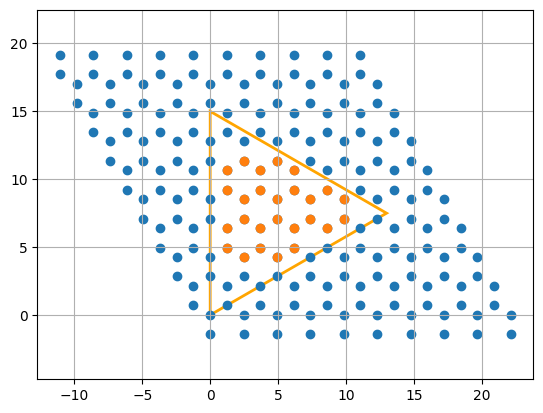

List with 26 orbitals, 26 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 26 orbitals


In [8]:
my_first_flake = graphene.cut_flake(triangle, plot = True)
print(my_first_flake)

For more information on cutting, including different edge types and how to keep dangling atoms, have a look at the corresponding tutorial.

## A first simulation

To get a feeling of the setup, we first inspect the energies of the flake

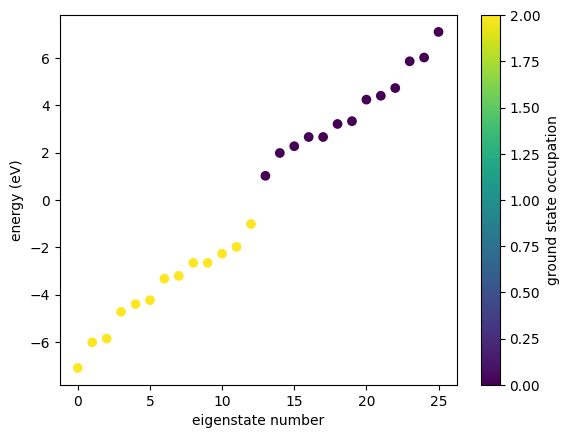

In [9]:
my_first_flake.show_energies()

Physical observables are expectation values of Hermitian operators. GRANAD offers access to the time-resolved density matrix $\rho(t)$ of a system by integrating a nonlinear master equation. As a result, it is possible to track the evolution of the physical observable associated with a Hermitian operator $A$ by computing $a(t) = Tr[\rho(t) A]$. Optical properties in particular are largely determined by the polarization or dipole operator $\hat{P}$ and they are usually expressed in frequency domain. To this end, GRANAD offers a way to compute the Fourier transform $a(\omega)$ directly after time propagation. We will look at an example tracking the time evolution of the dipole operator below, where the computation proceeds in two steps:


1. Excite the flake with an electric field.
2. Compute its dipole moment $p(\omega)$ from the expectation value of its dipole operator.

We first do step 1. To obtain a broad frequency spectrum, we must pick a narrow pulse in time-domain

In [10]:
from granad import Pulse

my_first_illumination = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
) 

For step 2, a few parameters have to be chosen

1. Simulation duration: we go from 0 to 40 in 1e5 steps.
2. Relaxation rate: this is $r$ in the dissipation term $D[\rho] = r \cdot(\rho - \rho_0)$ in the master equation.
3. Frequency domain limits: we choose the interval [0, 16].
4. Density matrix sampling rate: producing 1e5 density matrices can quickly exhaust RAM ressources. So we only save every 100th density matrix, such that we get 1000 density matrices.

A simulation is just passing all of these parameters to the corresponding method of our flake.

In [11]:
omegas, dipole_omega, pulse_omega =  my_first_flake.get_expectation_value_frequency_domain(
        operator=my_first_flake.dipole_operator, 
        end_time=40,
        steps_time=1e5,
        relaxation_rate=1 / 10,
        illumination=my_first_illumination,
        omega_min=0,
        omega_max=10,
        skip=100,
    )

We see that three variables are returned: the omega axis we have specified, the dipole moment and the pulse in freqeuency domain. There is no way to control the number of points in the omega axis, because it is the result of a Fourier transform.

We now plot the dipole moment and the pulse in frequency domain.

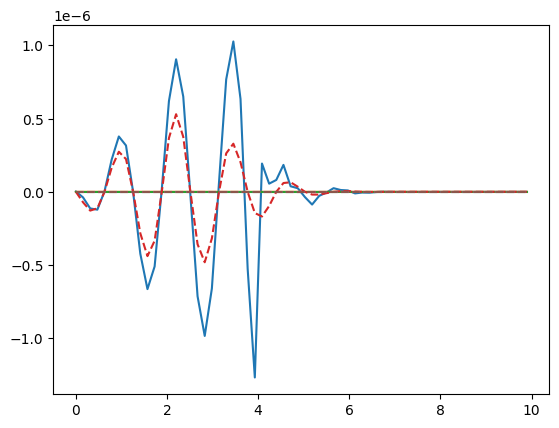

In [12]:
import matplotlib.pyplot as plt

plt.plot(omegas, dipole_omega)
plt.plot(omegas, pulse_omega, "--")
plt.show()